# Strategy

In this notebook, we attempt to train an inverse dynamics model (IDM). In Reinforcement Learning parlance, an IDM learns to predict $a_t$ given $s_t$ and $s_{t+1}$. In our case, we have access to the MetaDrive simulator and the Waymo dataset. We want to predict the action the car should take in MetaDrive so that the successor state in the simulator is as close as possible to the successor state in the Waymo dataset.

In [1]:
import typing
from dataclasses import dataclass
import numpy as np
import numpy.typing as npt

@dataclass
class State:
    heading: float
    velocity: npt.NDArray[np.float64]


Observation: typing.TypeAlias = tuple[State, State]
Action: typing.TypeAlias = tuple[float, float]

In [78]:
import metadrive
from metadrive import MetaDriveEnv
import gymnasium as gym
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F

def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

def normalize_angle(angle: float) -> float:
    """
    Normalize the angle to [-pi, pi)
    """
    return (angle + np.pi) % (2 * np.pi) - np.pi

def get_metadrive_state(env: MetaDriveEnv) -> State:
    return State(heading=env.vehicle.heading_theta, velocity=env.vehicle.velocity[:2])

def next_state(env: MetaDriveEnv, s: State, a: Action) -> State:
    """
    runs the policy and returns the total reward
    """
    # reset
    env.reset()
    env.vehicle.set_position(env.vehicle.position, height=0.49)

    # allow car to settle
    for _ in range(5):
        env.step([0,0])

    # set the initial state
    env.vehicle.set_velocity(s.velocity)
    env.vehicle.set_heading_theta(s.heading)
    
    # run the simulator
    env.step(a)

    # get the new state
    s_prime = get_metadrive_state(env)

    # allow car to settle (if rendering)
    if env.config.use_render:
        for _ in range(10):
            env.step([0,0])

    return s_prime

def gen_scenario() -> tuple[State, Action]:
    """
    Generates a random scenario
    """
    # generate a random state
    velocity = np.random.multivariate_normal([0, 0], np.eye(2) * 100)
    heading = normalize_angle(np.arctan2(velocity[1], velocity[0]) + np.random.normal(0, np.pi/4))

    s = State(heading=heading, velocity=velocity)

    # generate a random action
    steer = np.random.uniform(-1, 1)
    throttle = np.random.uniform(-1, 1)
    a = (steer, throttle)

    return s, a

def state_batch_to_tensor(states: list[State], device: torch.device) -> torch.Tensor:
    """
    Reshape the state from State to a tensor of shape (batch_size, 3)
    """

    return torch.tensor(np.stack([
        [st.velocity[0], st.velocity[1], st.heading] for st in states
    ]), dtype=torch.float32, device=device)

def action_batch_to_tensor(actions: list[Action], device: torch.device) -> torch.Tensor:
    """
    Reshape the action from Action to a tensor of shape (batch_size, 2)
    """
    return torch.tensor(np.stack(actions), dtype=torch.float32, device=device)

def obs_batch_to_tensor(obs: list[Observation], device: torch.device) -> torch.Tensor:
    """
    Reshape the observation from tuple[State, State] to a tensor of shape (batch_size, 3, 2)
    """

    observations = []

    for st0, st1 in obs:
        observations.append(np.array([
            [st0.velocity[0], st1.velocity[0]], 
            [st0.velocity[1], st1.velocity[1]],
            [st0.heading, st1.heading]
        ]))

    return torch.tensor(np.stack(observations), dtype=torch.float32, device=device)

This task may take a few minutes to run the first time.

In [79]:
from concurrent.futures import ProcessPoolExecutor
from metadrive import MetaDriveEnv

MAX_WORKERS = 16
DATASET_SIZE = 10000

def generate_data(n_scenarios: int) -> list[tuple[State, Action, State]]:
    env = MetaDriveEnv(config={"on_continuous_line_done": False, "use_render": False})
    dataset: list[tuple[State, Action, State]] = []
    for _ in range(n_scenarios):
        s0, a = gen_scenario()
        s1 = next_state(env, s0, a)
        dataset.append((s0, a, s1))
    env.close()
    return dataset

dataset: list[tuple[State, Action, State]] = []

with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    batch_size, leftover_size = divmod(DATASET_SIZE, MAX_WORKERS)
    for batch in executor.map(generate_data, [*[batch_size]*MAX_WORKERS, leftover_size]):
        dataset.extend(batch)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task((warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager
:task:task

In [167]:
validation_data = generate_data(1000)

:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


In [80]:
print(len(dataset))

10000


In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# create a model that attempts to predict the next state given the current state and the action: (throttle and steering)
# each state contains: velocity_x, velocity_y, and heading
class MetadriveModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3) + (batch_size, 2) = (batch_size, 5)
        # output shape: (batch_size, 3)
        self.fc1 = nn.Linear(5, 512) # Bx5 -> Bx512
        self.fc2 = nn.Linear(512, 512) # Bx512 -> Bx256
        self.fc3 = nn.Linear(512, 3) # Bx256 -> Bx3
    
    def forward(self, states: torch.Tensor, actions: torch.Tensor):
        x = torch.cat([states, actions], dim=1) # Bx5
        x = F.relu(self.fc1(x)) # Bx512
        x = F.relu(self.fc2(x)) # Bx512
        x = self.fc3(x) # Bx3
        return x

def train_metadrive_model_step(
    mm: MetadriveModel,
    mm_optimizer: torch.optim.Optimizer,
    s0_batch: list[State],
    a_batch: list[Action],
    s1_batch: list[State],
) -> float: 
    device = deviceof(mm)

    s0_tensor = state_batch_to_tensor(s0_batch, device) 
    a_tensor = action_batch_to_tensor(a_batch, device)
    s1_tensor = state_batch_to_tensor(s1_batch, device)

    mm_optimizer.zero_grad()
    s1_pred_tensor = mm(s0_tensor, a_tensor)
    loss = F.mse_loss(s1_pred_tensor, s1_tensor)
    loss.backward()
    mm_optimizer.step()
    return float(loss.item())



In [150]:
def set_lr(optimizer: torch.optim.Optimizer, lr: float) -> None:
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mm = MetadriveModel().to(device)

mm_optimizer = torch.optim.Adam(mm.parameters())

mm_step = 0
mm_losses = []

In [160]:
# make sure we don't run out of data
dataset_iter = iter(dataset*1000)

In [84]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [161]:
set_lr(mm_optimizer, 1e-5)
METADRIVE_MODEL_TRAIN_EPOCHS = 4000
METADRIVE_MODEL_TRAIN_BATCH_SIZE = 2048

while mm_step < METADRIVE_MODEL_TRAIN_EPOCHS:
    # take up to n from the data buffer
    data_batch = [next(dataset_iter) for _ in range(METADRIVE_MODEL_TRAIN_BATCH_SIZE)]
    # unpack the batch
    s0_batch = [s0 for s0, _, _ in data_batch]
    a_batch = [a for _, a, _ in data_batch]
    s1_batch = [s1 for _, _, s1 in data_batch]
    loss = train_metadrive_model_step(mm, mm_optimizer, s0_batch, a_batch, s1_batch)
    mm_losses.append(loss)
    mm_step += 1
    print(f"Step: {mm_step}, Loss: {loss:.3f}")

Step: 1953, Loss: 0.105
Step: 1954, Loss: 0.104
Step: 1955, Loss: 0.105
Step: 1956, Loss: 0.105
Step: 1957, Loss: 0.105
Step: 1958, Loss: 0.104
Step: 1959, Loss: 0.104
Step: 1960, Loss: 0.105
Step: 1961, Loss: 0.105
Step: 1962, Loss: 0.104
Step: 1963, Loss: 0.105
Step: 1964, Loss: 0.105
Step: 1965, Loss: 0.104
Step: 1966, Loss: 0.104
Step: 1967, Loss: 0.105
Step: 1968, Loss: 0.105
Step: 1969, Loss: 0.104
Step: 1970, Loss: 0.104
Step: 1971, Loss: 0.104
Step: 1972, Loss: 0.104
Step: 1973, Loss: 0.104
Step: 1974, Loss: 0.104
Step: 1975, Loss: 0.105
Step: 1976, Loss: 0.104
Step: 1977, Loss: 0.104
Step: 1978, Loss: 0.104
Step: 1979, Loss: 0.104
Step: 1980, Loss: 0.104
Step: 1981, Loss: 0.104
Step: 1982, Loss: 0.104
Step: 1983, Loss: 0.103
Step: 1984, Loss: 0.104
Step: 1985, Loss: 0.104
Step: 1986, Loss: 0.104
Step: 1987, Loss: 0.103
Step: 1988, Loss: 0.104
Step: 1989, Loss: 0.104
Step: 1990, Loss: 0.104
Step: 1991, Loss: 0.104
Step: 1992, Loss: 0.104
Step: 1993, Loss: 0.104
Step: 1994, Loss

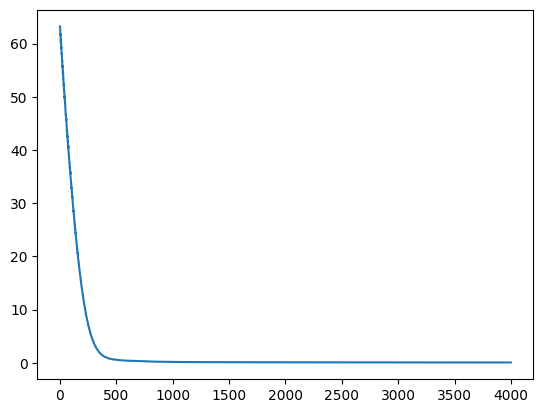

In [162]:
import matplotlib.pyplot as plt

# Plot the losses over training
plt.plot(list(range(len(mm_losses))), mm_losses, label='MM')
plt.show()

In [171]:
s0_batch = [s0 for s0, _, _ in validation_data]
s1_batch = [s1 for _, _, s1 in validation_data]
a_batch = [a for _, a, _ in validation_data]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print(loss.mean().item())

0.0765836089849472


tensor(0.0710, device='cuda:0', grad_fn=<MeanBackward0>)


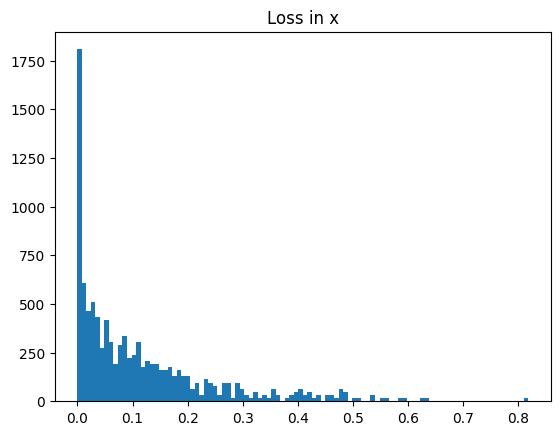

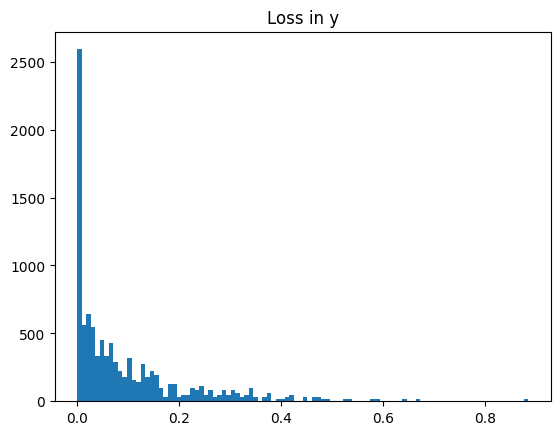

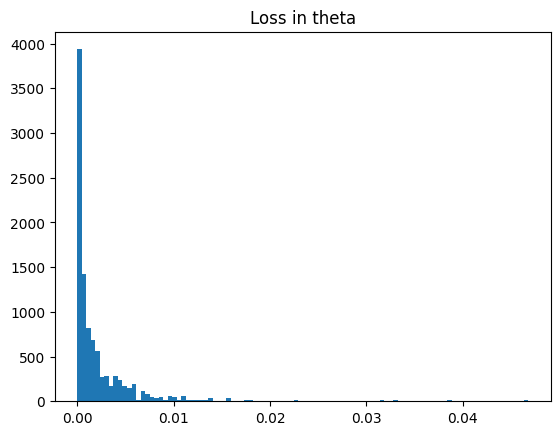

In [168]:
s0_batch = [s0 for s0, _, _ in dataset]
s1_batch = [s1 for _, _, s1 in dataset]
a_batch = [a for _, a, _ in dataset]

s0_tensor = state_batch_to_tensor(s0_batch, device)
s1_tensor = state_batch_to_tensor(s1_batch, device)
a_tensor = action_batch_to_tensor(a_batch, device)

s1_pred = mm(s0_tensor, a_tensor)

loss = (s1_pred - s1_tensor)**2
loss_x = loss[:, 0]
loss_y = loss[:, 1]
loss_theta = loss[:, 2]

print(loss.mean())

plt.hist(loss_x.cpu().detach().numpy(), bins=100)
plt.title('Loss in x')
plt.show()
plt.hist(loss_y.cpu().detach().numpy(), bins=100)
plt.title('Loss in y')
plt.show()
plt.hist(loss_theta.cpu().detach().numpy(), bins=100)
plt.title('Loss in theta')
plt.show()



In [164]:
(s1_tensor - s0_tensor)[10:20]


tensor([[-2.1768e-01,  1.8888e-01,  1.2054e-02],
        [ 6.2519e-02, -8.3508e-01, -3.2485e-06],
        [-4.5734e-01,  7.3288e-01, -1.0580e-04],
        [ 5.0727e-01,  4.4587e-01,  1.0980e-03],
        [-6.3876e-01,  5.0682e-01,  6.3348e-04],
        [ 6.9418e-01,  4.7359e-01, -2.2006e-04],
        [ 8.0162e-01,  1.3291e-01,  7.8046e-04],
        [-4.9212e-01, -6.5377e-01, -1.0452e-03],
        [-8.5614e-01,  9.2770e-02,  7.5459e-05],
        [ 8.3968e-01,  6.7720e-02,  5.2452e-06]], device='cuda:0')

In [165]:
(s1_pred - s0_tensor)[10:20]

tensor([[-0.5685, -0.0314,  0.0084],
        [-0.3019, -0.5145, -0.0263],
        [-0.3720,  0.2469,  0.0752],
        [-0.1301,  0.1892, -0.0452],
        [-0.2383,  0.5546,  0.0334],
        [ 0.5607,  0.4675, -0.0051],
        [ 0.0705, -0.3087,  0.0113],
        [-0.4600, -0.6457,  0.0402],
        [-0.6262,  0.4614,  0.0460],
        [ 0.5090,  0.4448, -0.0358]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [166]:
(s1_pred - s1_tensor)[10:20]

tensor([[-0.3508, -0.2203, -0.0036],
        [-0.3644,  0.3205, -0.0263],
        [ 0.0854, -0.4860,  0.0753],
        [-0.6374, -0.2566, -0.0463],
        [ 0.4004,  0.0478,  0.0327],
        [-0.1334, -0.0061, -0.0049],
        [-0.7312, -0.4416,  0.0106],
        [ 0.0321,  0.0081,  0.0412],
        [ 0.2300,  0.3686,  0.0459],
        [-0.3307,  0.3771, -0.0358]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Now that we have trained a neural network model of Metadrive through which we can backprop, training the IDM is easy.

In [ ]:
# creates a model that attempts to predict the action given the current state and the next state
class InverseDynamicsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input shape: (batch_size, 3, 2)
        # output shape: (batch_size, 2)

        self.conv1 = nn.Conv1d(3, 512, 2) # Bx3x2 -> Bx512x1
        self.fc1 = nn.Linear(512, 256) # Bx512 -> Bx256
        self.fc2 = nn.Linear(256, 256) # Bx256 -> Bx256
        self.fc3 = nn.Linear(256, 2) # Bx256 -> Bx2
    
    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x)) # Bx3x2 -> Bx512x1
        x = torch.flatten(x, 1) # Bx512x1 -> Bx512
        x = F.relu(self.fc1(x)) # Bx512 -> Bx256
        x = F.relu(self.fc2(x)) # Bx256 -> Bx256
        x = self.fc3(x) # Bx256 -> Bx2
        return x

def train_idm_step(
        mm: MetadriveModel,
        idm: InverseDynamicsModel,
        idm_optimizer: torch.optim.Optimizer,
        obs_batch: list[Observation],
) -> float:
    device = deviceof(mm)

    assert deviceof(idm) == device

    obs_tensor = obs_batch_to_tensor(obs_batch, device)
    s0_batch = state_batch_to_tensor([s0 for s0, _ in obs_batch], device)
    s1_batch = state_batch_to_tensor([s1 for _, s1 in obs_batch], device)

    idm_optimizer.zero_grad()

    pred_action = idm(obs_tensor)
    pred_s1 = mm(s0_batch, pred_action)

    loss = F.mse_loss(pred_s1, s1_batch)
    loss.backward()

    idm_optimizer.step()

    return float(loss.item())

In [ ]:
from protos import scenario_pb2
from tensorflow.data import TFRecordDataset
import tqdm
import os

def getFiles(path: str) -> list[str]:
    path = os.path.expanduser(path)
    files = [os.path.join(path, f) for f in os.listdir(path)]
    return [f for f in files if os.path.isfile(f)]


files = getFiles('~/data/waymo/')

def parse_scenario(scenario: scenario_pb2.Scenario) -> list[State]:
    states = []
    for s in scenario.tracks[scenario.sdc_track_index].states:
        if s.valid:
            states.append(State(s.heading, np.array([s.velocity_x, s.velocity_y], dtype=np.float32)))
    return states


h: list[list[State]] = []

for file_path in tqdm.tqdm(files):
    for data in TFRecordDataset(file_path, compression_type="").as_numpy_iterator():
        scenario = scenario_pb2.Scenario()
        scenario.ParseFromString(data)
        h.append(parse_scenario(scenario))


2023-08-10 19:36:32.198575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 19:36:33.251851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  0%|          | 0/100 [00:00<?, ?it/s]2023-08-10 19:36:34.065985: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-10 19:36:34.085071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at l

KeyboardInterrupt: 

In [ ]:
dataset: list[Observation] = []
for states in h:
    for i in range(len(states)-1):
        dataset.append((states[i], states[i+1]))

In [ ]:
import random
random.shuffle(dataset)

In [ ]:
idm = InverseDynamicsModel().to(device)

idm_optimizer = torch.optim.Adam(idm.parameters())

idm_step = 0
idm_losses = []

In [ ]:
set_lr(idm_optimizer, 1e-4)
INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS = 1000
INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE = 128

while idm_step < INVERSE_DYNAMICS_MODEL_TRAIN_EPOCHS:
    idm_step += 1
    idm_batch = idm_train_ds.sample(INVERSE_DYNAMICS_MODEL_TRAIN_BATCH_SIZE)
    idm_loss = idm_train_step(idm_batch)
    if idm_step % 50 == 0:
        print(f"IDM Step {idm_step}: {idm_loss:.4f}")